### Install and import all the requirements

In [11]:
!pip install -qU vaderSentiment textstat xgboost wordcloud textblob

ERROR: Could not install packages due to an OSError: [WinError 2] The system cannot find the file specified: 'C:\\Python312\\Scripts\\nltk.exe' -> 'C:\\Python312\\Scripts\\nltk.exe.deleteme'



In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
import re
from datetime import datetime
import plotly.express as px
import plotly.graph_objects as go
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import textstat
from transformers import AutoTokenizer, AutoModel
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

ModuleNotFoundError: No module named 'wordcloud'

### Load the dataset

In [3]:
df = pd.read_csv('./train.tsv', sep='\t')

In [ ]:
df

,Unnamed: 0,title,text,subject,date,label
0,2619,Ex-CIA head says Trump remarks on Russia inter...,Former CIA director John Brennan on Friday cri...,politicsNews,"July 22, 2017",1
1,16043,YOU WON’T BELIEVE HIS PUNISHMENT! HISPANIC STO...,How did this man come to OWN this store? There...,Government News,"Jun 19, 2017",0
2,876,Federal Reserve governor Powell's policy views...,President Donald Trump on Thursday tapped Fede...,politicsNews,"November 2, 2017",1
3,19963,SCOUNDREL HILLARY SUPPORTER STARTS “TrumpLeaks...,Hillary Clinton ally David Brock is offering t...,left-news,"Sep 17, 2016",0
4,10783,NANCY PELOSI ARROGANTLY DISMISSES Questions on...,Pleading ignorance is a perfect ploy for Nancy...,politics,"May 26, 2017",0
...,...,...,...,...,...,...
29995,6880,U.S. aerospace industry urges Trump to help Ex...,The chief executive of the U.S. Aerospace Indu...,politicsNews,"December 6, 2016",1
29996,17818,Highlights: Hong Kong leader Carrie Lam delive...,The following are highlights of the maiden pol...,worldnews,"October 11, 2017",1
29997,5689,Obama Literally LAUGHS At Claims That Brexit M...,If there s one thing President Barack Obama is...,News,"June 28, 2016",0
29998,15805,Syrian army takes full control of Deir al-Zor ...,The Syrian army and its allies have taken full...,worldnews,"November 2, 2017",1


### Exploratory Data Analysis (EDA) for gaining insights



In [5]:
print("Downloading required NLTK data...")
try:
    nltk.download('punkt')
    nltk.download('stopwords')
    nltk.download('averaged_perceptron_tagger')
    print("NLTK downloads completed successfully!")
except Exception as e:
    print(f"Error downloading NLTK data: {e}")
    print("Continuing with limited functionality...")

def is_valid_date(date_str):
    """
    Check if a string looks like a valid date
    """
    date_str = str(date_str).strip()

    # Check if string contains typical date patterns
    date_patterns = [
        r'\b\w+\s+\d{1,2},\s+\d{4}\b',  # Month DD, YYYY
        r'\b\w{3}\s+\d{1,2},\s+\d{4}\b'  # MMM DD, YYYY
    ]

    return any(re.match(pattern, date_str) for pattern in date_patterns)

def load_and_preprocess(df):
    """
    Load and preprocess the dataset with data cleaning
    """
    print("Original dataset size:", len(df))

    # Filter out rows with invalid dates
    df = df[df['date'].apply(is_valid_date)].copy()
    print("Dataset size after cleaning dates:", len(df))

    # Convert clean dates to datetime
    df['date'] = pd.to_datetime(df['date'].str.strip(), format='mixed')

    # Create basic features
    df['title_length'] = df['title'].str.len()
    df['text_length'] = df['text'].str.len()
    df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))

    return df

def get_sentiment_scores(text):
    """
    Get sentiment polarity scores using TextBlob
    """
    return TextBlob(str(text)).sentiment.polarity

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


NLTK downloads completed successfully!


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [6]:
plt.style.use('default')

df = load_and_preprocess(df)

print("Calculating sentiment scores...")
df['sentiment_score'] = df['text'].apply(get_sentiment_scores)

Original dataset size: 20103
Dataset size after cleaning dates: 20082
Calculating sentiment scores...


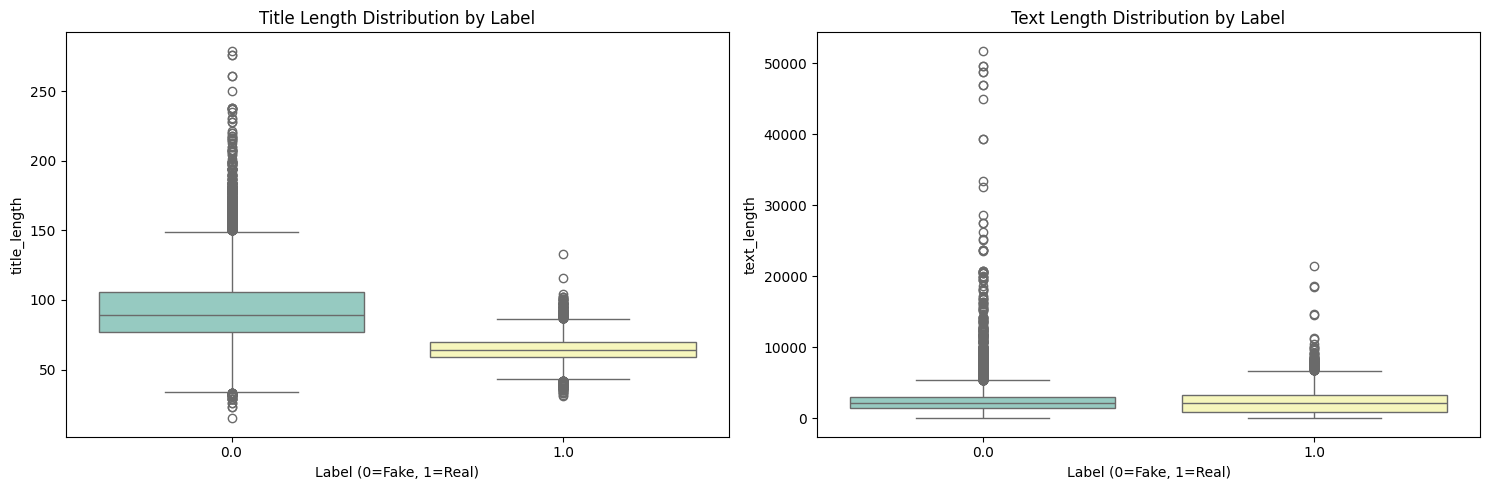

In [7]:
# 1. Length Distributions
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.boxplot(x='label', y='title_length', data=df, palette='Set3')
plt.title('Title Length Distribution by Label')
plt.xlabel('Label (0=Fake, 1=Real)')

plt.subplot(1, 2, 2)
sns.boxplot(x='label', y='text_length', data=df, palette='Set3')
plt.title('Text Length Distribution by Label')
plt.xlabel('Label (0=Fake, 1=Real)')
plt.tight_layout()
plt.show()

<Figure size 1500x500 with 0 Axes>

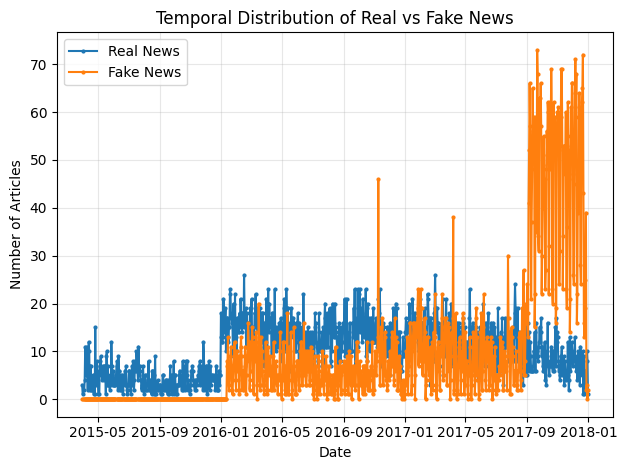

In [8]:
# 2. Temporal Analysis
plt.figure(figsize=(15, 5))
temporal_data = df.groupby([df['date'].dt.date, 'label']).size().unstack(fill_value=0)
temporal_data.plot(kind='line', marker='o', markersize=2)
plt.title('Temporal Distribution of Real vs Fake News')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.legend(['Real News', 'Fake News'])
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Generating word clouds...


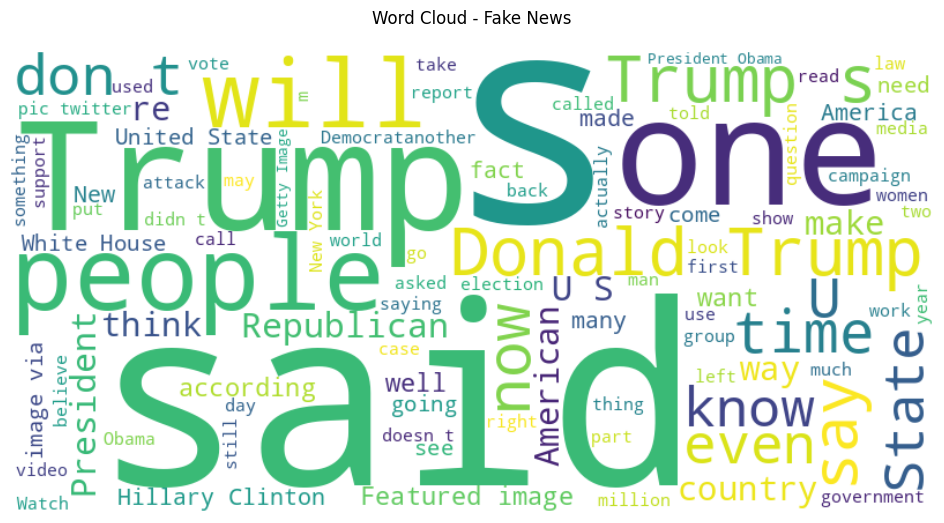

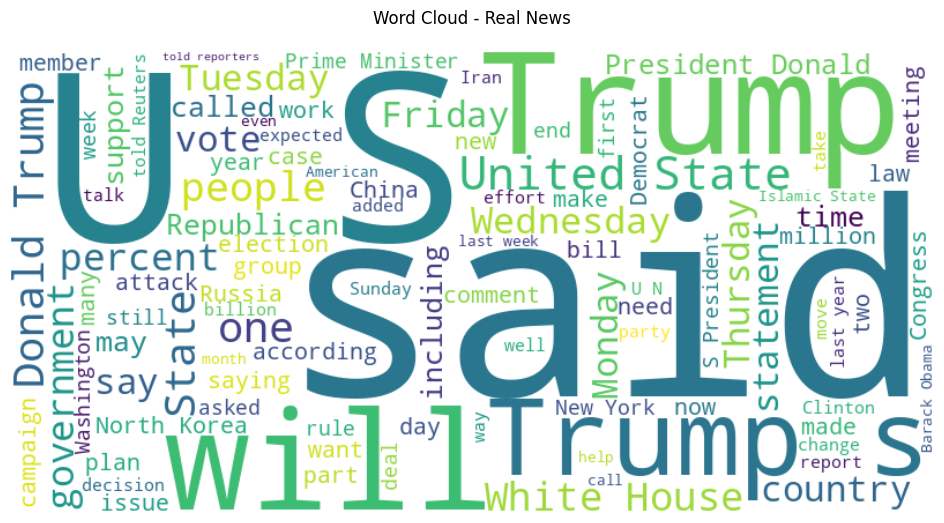

In [9]:
# 3. Word Clouds
print("Generating word clouds...")
# Fake News WordCloud
fake_text = ' '.join(df[df['label'] == 0]['text'].astype(str))
plt.figure(figsize=(12, 6))
wordcloud = WordCloud(width=800, height=400, background_color='white',
                      stopwords=set(STOPWORDS), max_words=100,
                      colormap='viridis').generate(fake_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Fake News', pad=20)
plt.show()

# Real News WordCloud
real_text = ' '.join(df[df['label'] == 1]['text'].astype(str))
plt.figure(figsize=(12, 6))
wordcloud = WordCloud(width=800, height=400, background_color='white',
                      stopwords=set(STOPWORDS), max_words=100,
                      colormap='viridis').generate(real_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Real News', pad=20)
plt.show()

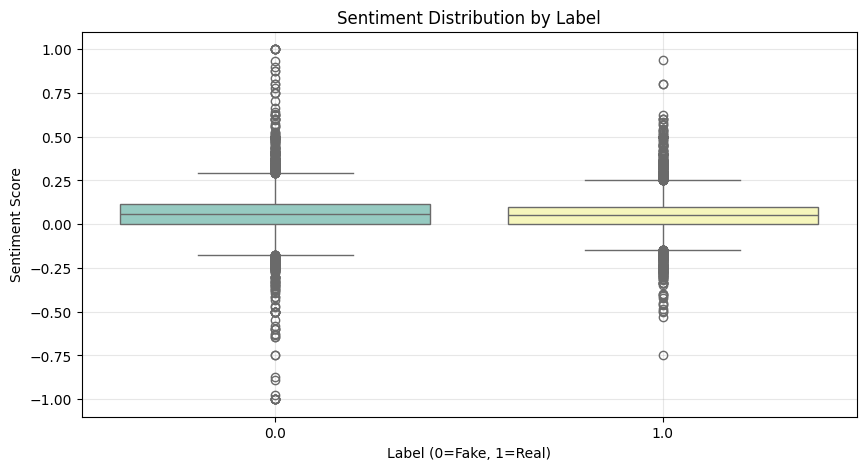

In [10]:
# 4. Sentiment Analysis
plt.figure(figsize=(10, 5))
sns.boxplot(x='label', y='sentiment_score', data=df, palette='Set3')
plt.title('Sentiment Distribution by Label')
plt.xlabel('Label (0=Fake, 1=Real)')
plt.ylabel('Sentiment Score')
plt.grid(True, alpha=0.3)
plt.show()

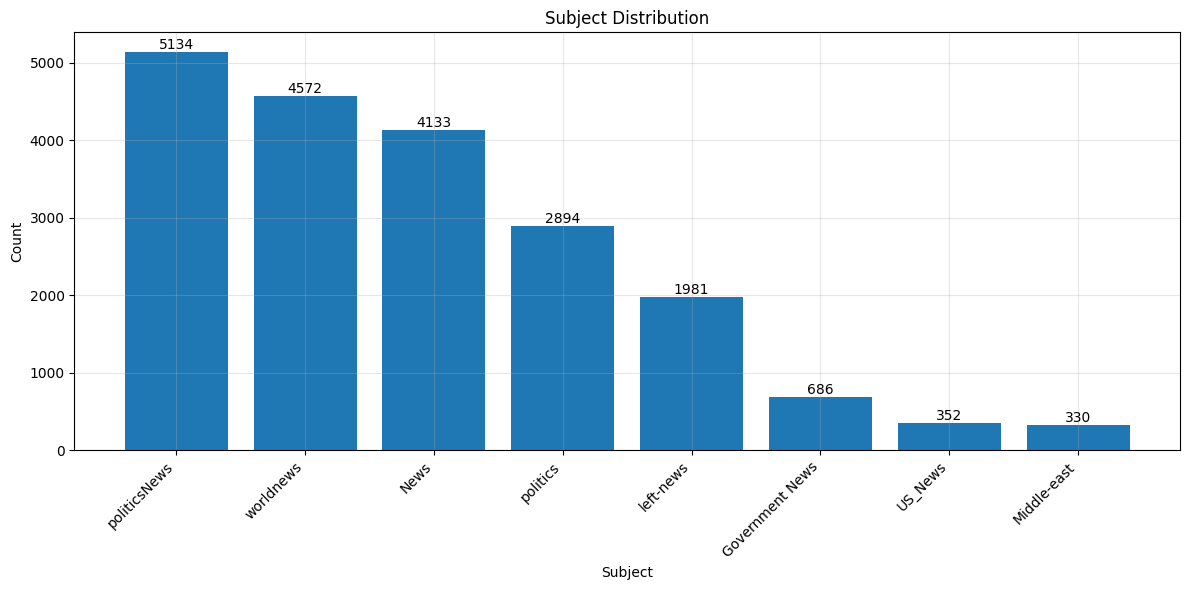

In [11]:
# 5. Subject Distribution
if 'subject' in df.columns:
    plt.figure(figsize=(12, 6))
    subject_counts = df['subject'].value_counts()
    bars = plt.bar(range(len(subject_counts)), subject_counts.values)
    plt.title('Subject Distribution')
    plt.xticks(range(len(subject_counts)), subject_counts.index, rotation=45, ha='right')
    plt.xlabel('Subject')
    plt.ylabel('Count')

    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}', ha='center', va='bottom')

    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [12]:
# 6. Print Summary Statistics
print("\n=== Summary Statistics ===")
print("\nAverage Title Length:")
print(df.groupby('label')['title_length'].mean().round(2))
print("\nAverage Text Length:")
print(df.groupby('label')['text_length'].mean().round(2))
print("\nAverage Sentiment Score:")
print(df.groupby('label')['sentiment_score'].mean().round(4))


=== Summary Statistics ===

Average Title Length:
label
0.0    94.25
1.0    64.59
Name: title_length, dtype: float64

Average Text Length:
label
0.0    2600.12
1.0    2357.72
Name: text_length, dtype: float64

Average Sentiment Score:
label
0.0    0.0611
1.0    0.0544
Name: sentiment_score, dtype: float64


### Preprocessing the Dataset

- Feature Extraction: Extract text features (length, keyword density, sentiment, linguistic features like readability and punctuation, embeddings, one hot encoding).
- Data Cleaning: Remove punctuation, convert to lowercase, and strip whitespace.

In [7]:
# Preprocessing text
def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = text.lower().strip()         # Convert to lowercase and strip whitespace
    return text

df['clean_title'] = df['title'].apply(clean_text)
df['clean_text'] = df['text'].apply(clean_text)

# 1. Numerical Features
df['title_length'] = df['clean_title'].apply(len)  # Title Length
df['text_length'] = df['clean_text'].apply(len)    # Text Length
df['keyword_density'] = df['clean_text'].apply(lambda x: sum(word in x for word in ['shocking', 'exclusive', 'breaking']) / len(x.split()))

# 2. Sentiment Features
analyzer = SentimentIntensityAnalyzer()

def sentiment_scores(text):
    scores = analyzer.polarity_scores(text)
    return scores['pos'], scores['neg'], scores['neu']

df[['title_pos_sentiment', 'title_neg_sentiment', 'title_neu_sentiment']] = df['clean_title'].apply(lambda x: pd.Series(sentiment_scores(x)))
df[['text_pos_sentiment', 'text_neg_sentiment', 'text_neu_sentiment']] = df['clean_text'].apply(lambda x: pd.Series(sentiment_scores(x)))

# 3. Linguistic Features
def readability_scores(text):
    try:
        return textstat.flesch_kincaid_grade(text)  # Flesch-Kincaid readability score
    except:
        return np.nan

df['readability_score'] = df['clean_text'].apply(readability_scores)

df['punctuation_count'] = df['text'].apply(lambda x: sum(1 for char in x if char in ['!', '.', '?', ',']))

# 4. Text Embeddings (BERT/RoBERTa)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModel.from_pretrained("bert-base-uncased").to(device)

def extract_embeddings(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    # Use the [CLS] token embedding
    return outputs.last_hidden_state[:, 0, :].cpu().numpy().flatten()

df['text_embeddings'] = df['clean_text'].apply(lambda x: extract_embeddings(x))

# Dimensionality Reduction (optional)
embedding_matrix = np.stack(df['text_embeddings'].values)
svd = TruncatedSVD(n_components=50, random_state=42)
reduced_embeddings = svd.fit_transform(embedding_matrix)
for i in range(reduced_embeddings.shape[1]):
    df[f'embedding_dim_{i+1}'] = reduced_embeddings[:, i]

NameError: name 're' is not defined

In [14]:
# 5. Temporal Features
df['date'] = df['date'].astype(str).str.strip()

print("\nOriginal shape:", df.shape)

def is_likely_date(s):
    # Check for common date patterns
    date_patterns = [
        r'\d{1,2}[-/]\d{1,2}[-/]\d{2,4}',  # matches 01/01/2020, 1-1-20
        r'[A-Za-z]{3,9}\s+\d{1,2},?\s+\d{4}',  # matches July 1, 2020 or Jul 1 2020
        r'\d{1,2}\s+[A-Za-z]{3,9}\s+\d{4}'  # matches 1 July 2020
    ]
    return any(re.search(pattern, str(s)) for pattern in date_patterns)

# Filter to keep only likely dates
import re
mask = df['date'].apply(is_likely_date)
df = df[mask].copy()

print("Shape after filtering:", df.shape)

df['date'] = pd.to_datetime(df['date'], format='mixed')
df['day'] = df['date'].dt.day
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

# Final dataframe
df = df.drop(['title', 'text', 'text_embeddings'], axis=1)
print(df)


Original shape: (20082, 72)
Shape after filtering: (20082, 72)
       Unnamed: 0          subject       date  label  title_length  \
0            2619     politicsNews 2017-07-22    1.0            64   
1           16043  Government News 2017-06-19    0.0           115   
2             876     politicsNews 2017-11-02    1.0            62   
3           19963        left-news 2016-09-17    0.0            68   
4           10783         politics 2017-05-26    0.0           102   
...           ...              ...        ...    ...           ...   
20097       12132        worldnews 2017-12-16    1.0            70   
20098        2766     politicsNews 2017-07-13    1.0            57   
20099       20509        left-news 2016-05-28    0.0            97   
20100       14357         politics 2016-03-06    0.0            84   
20101       13289         politics 2016-08-10    0.0            77   

       text_length  word_count  sentiment_score  \
0             2658         433        -0.043

In [15]:
def summary(df):
    print(f'data shape: {df.shape}')
    summ = pd.DataFrame(df.dtypes, columns=['data type'])
    summ['#missing'] = df.isnull().sum().values
    summ['%missing'] = df.isnull().sum().values / len(df)* 100
    summ['#unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values
    return summ

print(summary(df))

data shape: (20082, 72)
                       data type  #missing  %missing  #unique  \
Unnamed: 0                 int64         0       0.0    15866   
subject                   object         0       0.0        8   
date              datetime64[ns]         0       0.0      996   
label                    float64         0       0.0        2   
title_length               int64         0       0.0      187   
...                          ...       ...       ...      ...   
embedding_dim_49         float32         0       0.0    18850   
embedding_dim_50         float32         0       0.0    18851   
day                        int32         0       0.0       31   
month                      int32         0       0.0       12   
year                       int32         0       0.0        3   

                                  min                  max  
Unnamed: 0                        0.0              23475.0  
subject                           NaN                  NaN  
date        

In [16]:
df['subject'].value_counts()

,count
subject,
politicsNews,5134
worldnews,4572
News,4133
politics,2894
left-news,1981
Government News,686
US_News,352
Middle-east,330


In [17]:
one_hot_encoded = pd.get_dummies(df['subject'], prefix='subject')

df = pd.concat([df, one_hot_encoded], axis=1)

In [18]:
df.head()

,Unnamed: 0,subject,date,label,title_length,text_length,word_count,sentiment_score,clean_title,clean_text,...,month,year,subject_Government News,subject_Middle-east,subject_News,subject_US_News,subject_left-news,subject_politics,subject_politicsNews,subject_worldnews
0,2619,politicsNews,2017-07-22,1.0,64,2658,433,-0.043050,excia head says trump remarks on russia interf...,former cia director john brennan on friday cri...,...,7,2017,False,False,False,False,False,False,True,False
1,16043,Government News,2017-06-19,0.0,115,2556,434,0.143120,you wont believe his punishment hispanic store...,how did this man come to own this store there ...,...,6,2017,True,False,False,False,False,False,False,False
2,876,politicsNews,2017-11-02,1.0,62,3921,643,0.040277,federal reserve governor powells policy views ...,president donald trump on thursday tapped fede...,...,11,2017,False,False,False,False,False,False,True,False
3,19963,left-news,2016-09-17,0.0,68,1114,195,0.253828,scoundrel hillary supporter starts trumpleaks ...,hillary clinton ally david brock is offering t...,...,9,2016,False,False,False,False,True,False,False,False
4,10783,politics,2017-05-26,0.0,102,1043,170,0.077083,nancy pelosi arrogantly dismisses questions on...,pleading ignorance is a perfect ploy for nancy...,...,5,2017,False,False,False,False,False,True,False,False


In [19]:
train = df.drop(columns = ['subject','date','clean_title','clean_text','Unnamed: 0'], axis = 1)

### Expert 1: Classical ML Model Training


In [ ]:
X = train.drop(['label'], axis=1)
y = train['label']

NameError: name 'train' is not defined

In [21]:
X.columns

Index(['title_length', 'text_length', 'word_count', 'sentiment_score',
       'keyword_density', 'title_pos_sentiment', 'title_neg_sentiment',
       'title_neu_sentiment', 'text_pos_sentiment', 'text_neg_sentiment',
       'text_neu_sentiment', 'readability_score', 'punctuation_count',
       'embedding_dim_1', 'embedding_dim_2', 'embedding_dim_3',
       'embedding_dim_4', 'embedding_dim_5', 'embedding_dim_6',
       'embedding_dim_7', 'embedding_dim_8', 'embedding_dim_9',
       'embedding_dim_10', 'embedding_dim_11', 'embedding_dim_12',
       'embedding_dim_13', 'embedding_dim_14', 'embedding_dim_15',
       'embedding_dim_16', 'embedding_dim_17', 'embedding_dim_18',
       'embedding_dim_19', 'embedding_dim_20', 'embedding_dim_21',
       'embedding_dim_22', 'embedding_dim_23', 'embedding_dim_24',
       'embedding_dim_25', 'embedding_dim_26', 'embedding_dim_27',
       'embedding_dim_28', 'embedding_dim_29', 'embedding_dim_30',
       'embedding_dim_31', 'embedding_dim_32', 'emb

In [22]:
fit_columns_list = X.columns.tolist()

In [23]:
# Initialize models
gbr = GradientBoostingClassifier(random_state=42)
rfc = RandomForestClassifier(random_state=42)
log_reg = LogisticRegression(random_state=42, max_iter=1000)
xgbc = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Initialize K-Fold and metric containers
kf = KFold(n_splits=5, shuffle=True, random_state=42)
metrics = {
    "accuracy": [],
    "precision": [],
    "recall": [],
    "f1": [],
    "roc_auc": []
}

# K-Fold cross-validation
for train_index, test_index in kf.split(X):
    x_train_fold, x_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

    # Train models
    gbr.fit(x_train_fold, y_train_fold)
    rfc.fit(x_train_fold, y_train_fold)
    log_reg.fit(x_train_fold, y_train_fold)
    xgbc.fit(x_train_fold, y_train_fold)

    # Predict probabilities and combine predictions
    y_pred_proba_gbr = gbr.predict_proba(x_test_fold)[:, 1]
    y_pred_proba_rfc = rfc.predict_proba(x_test_fold)[:, 1]
    y_pred_proba_log_reg = log_reg.predict_proba(x_test_fold)[:, 1]
    y_pred_proba_xgbc = xgbc.predict_proba(x_test_fold)[:, 1]

    # Ensemble prediction (average probabilities)
    y_pred_proba_ensemble = (
        y_pred_proba_gbr + y_pred_proba_rfc + y_pred_proba_log_reg + y_pred_proba_xgbc
    ) / 4
    y_pred_ensemble = (y_pred_proba_ensemble >= 0.5).astype(int)

    # Compute metrics
    metrics["accuracy"].append(accuracy_score(y_test_fold, y_pred_ensemble))
    metrics["precision"].append(precision_score(y_test_fold, y_pred_ensemble))
    metrics["recall"].append(recall_score(y_test_fold, y_pred_ensemble))
    metrics["f1"].append(f1_score(y_test_fold, y_pred_ensemble))
    metrics["roc_auc"].append(roc_auc_score(y_test_fold, y_pred_proba_ensemble))

# Calculate average metrics across folds
average_metrics = {metric: np.mean(values) for metric, values in metrics.items()}

# Print results
for metric, value in average_metrics.items():
    print(f"Average {metric.capitalize()}: {value:.4f}")

Average Accuracy: 1.0000
Average Precision: 1.0000
Average Recall: 1.0000
Average F1: 1.0000
Average Roc_auc: 1.0000


In [24]:
# Now let's check for suspiciously predictive individual features
for column in X.columns:
    single_feature = X[[column]]
    clf = LogisticRegression(random_state=42)
    scores = cross_val_score(clf, single_feature, y, cv=5)
    print(f"{column}: {scores.mean():.4f}")

# Look for near-constant or unique columns
print("\nNumber of unique values per column:")
print(X.nunique().sort_values(ascending=True))

# Check for data leakage via correlation
correlations = X.corrwith(y).abs().sort_values(ascending=False)
print("\nHighest absolute correlations with target:")
print(correlations.head())

title_length: 0.8230
text_length: 0.5638
word_count: 0.5587
sentiment_score: 0.5016
keyword_density: 0.5167
title_pos_sentiment: 0.5167
title_neg_sentiment: 0.5983
title_neu_sentiment: 0.5569
text_pos_sentiment: 0.5376
text_neg_sentiment: 0.5709
text_neu_sentiment: 0.5726
readability_score: 0.5579
punctuation_count: 0.5568
embedding_dim_1: 0.5906
embedding_dim_2: 0.7014
embedding_dim_3: 0.7944
embedding_dim_4: 0.6208
embedding_dim_5: 0.5304
embedding_dim_6: 0.5167
embedding_dim_7: 0.5480
embedding_dim_8: 0.5493
embedding_dim_9: 0.5267
embedding_dim_10: 0.5243
embedding_dim_11: 0.5287
embedding_dim_12: 0.5487
embedding_dim_13: 0.5456
embedding_dim_14: 0.5195
embedding_dim_15: 0.5241
embedding_dim_16: 0.5441
embedding_dim_17: 0.5125
embedding_dim_18: 0.5189
embedding_dim_19: 0.5167
embedding_dim_20: 0.5131
embedding_dim_21: 0.5166
embedding_dim_22: 0.5315
embedding_dim_23: 0.5396
embedding_dim_24: 0.5288
embedding_dim_25: 0.5167
embedding_dim_26: 0.5622
embedding_dim_27: 0.5475
embedding

In [25]:
print(y.value_counts())


label
0.0    10376
1.0     9706
Name: count, dtype: int64


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix for the ensemble model's predictions
cm = confusion_matrix(y_test_fold, y_pred_ensemble)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Fake', 'Predicted Real'], yticklabels=['Actual Fake', 'Actual Real'])
plt.title('Confusion Matrix for Ensemble Model')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.show()

### Expert 2: Trandformer Model training

In [26]:
# Prepare dataset
og_df = pd.read_csv('/content/train.tsv', sep='\t')
og_df = og_df.dropna(subset=['label'])
og_df['combined_text'] = og_df['title'] + " - " + og_df['text'] + " - " + og_df['subject']
texts = og_df['combined_text'].tolist()
labels = og_df['label'].tolist()

# Train-test split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42, stratify=labels
)

# Tokenization
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512, return_tensors="pt")
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=512, return_tensors="pt")

# Define PyTorch Dataset
class FakeNewsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: self.encodings[key][idx] for key in self.encodings}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

train_dataset = FakeNewsDataset(train_encodings, train_labels)
val_dataset = FakeNewsDataset(val_encodings, val_labels)

# Load pre-trained BERT model
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

# Define evaluation function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.argmax(torch.tensor(logits), dim=-1).numpy()
    probabilities = torch.softmax(torch.tensor(logits), dim=-1)[:, 1].numpy()

    acc = accuracy_score(labels, predictions)
    prec = precision_score(labels, predictions, average='binary')
    rec = recall_score(labels, predictions, average='binary')
    f1 = f1_score(labels, predictions, average='binary')
    auc = roc_auc_score(labels, probabilities)

    return {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1, "roc_auc": auc}

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=2,
    max_steps=500,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    warmup_steps=50,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=50,
    evaluation_strategy="steps",
    save_strategy="steps",
    save_steps=50,  # Save checkpoints more frequently
    save_total_limit=2,  # Retain only the last 2 checkpoints
    load_best_model_at_end=True,
    fp16=True,
    gradient_accumulation_steps=2,
)

# Trainer setup
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

# Train the Transformer model
trainer.train()

# Evaluate the Transformer model
eval_results = trainer.evaluate()
print("Evaluation Results:", eval_results)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Roc Auc
50,1.050000,0.184230,0.934500,0.884533,0.994490,0.936294,0.994763
100,0.316400,0.077351,0.985000,0.976303,0.993113,0.984636,0.998352
150,0.193800,0.056591,0.987500,0.978680,0.995868,0.987199,0.999305
200,0.206100,0.033853,0.993500,0.997223,0.989325,0.993258,0.999551
250,0.107600,0.019720,0.995833,0.998269,0.993113,0.995684,0.999660
300,0.088200,0.071349,0.988500,0.977433,0.999311,0.988251,0.999730
350,0.038700,0.024517,0.995667,0.994842,0.996212,0.995526,0.999715
400,0.075000,0.073494,0.989167,0.978752,0.999311,0.988925,0.999778
450,0.042800,0.026689,0.995500,0.991795,0.998967,0.995368,0.999773
500,0.083100,0.022927,0.996167,0.993153,0.998967,0.996052,0.999805


Evaluation Results: {'eval_loss': 0.019719598814845085, 'eval_accuracy': 0.9958333333333333, 'eval_precision': 0.9982692973347179, 'eval_recall': 0.9931129476584022, 'eval_f1': 0.9956844467460728, 'eval_roc_auc': 0.9996596514831186, 'eval_runtime': 52.4513, 'eval_samples_per_second': 114.392, 'eval_steps_per_second': 28.598, 'epoch': 0.16666666666666666}


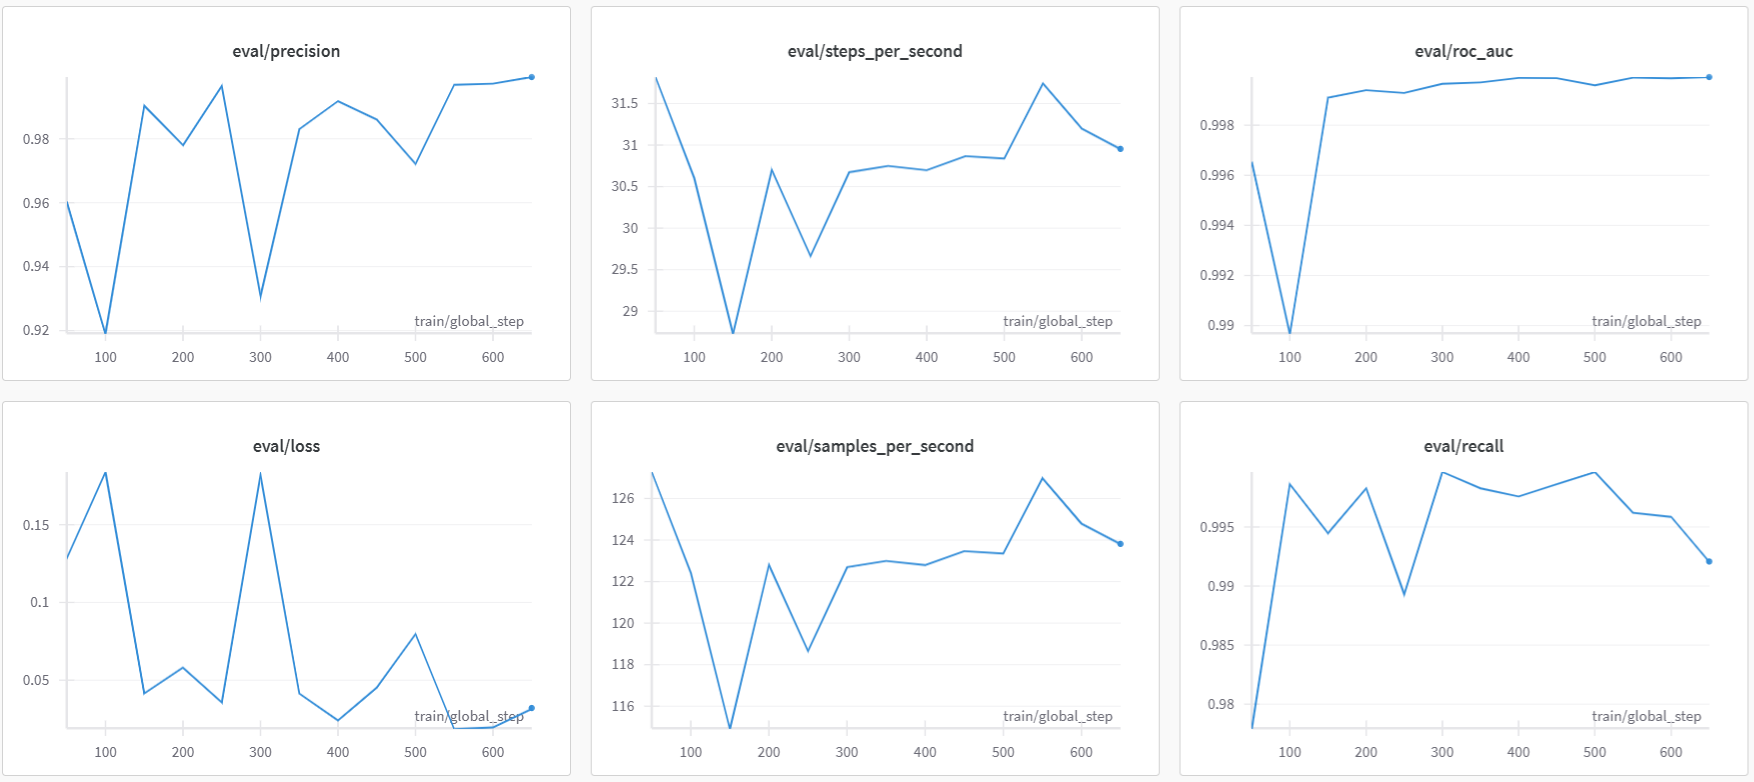

### Mixture of Experts: Gate Training

In [27]:
import torch
import pandas as pd
import numpy as np
from textstat import textstat
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from transformers import AutoTokenizer, AutoModel
from sklearn.decomposition import TruncatedSVD
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from tqdm.auto import tqdm
from sklearn.impute import SimpleImputer

class GatingNetwork(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 2),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        return self.net(x)

class MOEPreprocessor:
    def __init__(self, bert_tokenizer, bert_model, classical_models=None, gate=None, batch_size=8):
        self.tokenizer = bert_tokenizer
        self.bert_model = bert_model
        self.classical_models = classical_models
        self.gate = gate
        self.batch_size = batch_size
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.analyzer = SentimentIntensityAnalyzer()
        self.svd = TruncatedSVD(n_components=50, random_state=42)
        torch.set_default_tensor_type(torch.FloatTensor)
        self.feature_columns = None
        self.subject_categories = None

    def clean_text(self, text):
        if pd.isna(text):
            return ""
        text = re.sub(r'[^\w\s]', '', str(text))
        return text.lower().strip()

    def sentiment_scores(self, text):
        if pd.isna(text) or text == "":
            return 0, 0, 0
        scores = self.analyzer.polarity_scores(text)
        return scores['pos'], scores['neg'], scores['neu']

    def readability_scores(self, text):
        if pd.isna(text) or text == "":
            return 0
        try:
            return textstat.flesch_kincaid_grade(text)
        except:
            return 0

    def extract_embeddings(self, text):
        if pd.isna(text) or text == "":
            return np.zeros(768)
        inputs = self.tokenizer(str(text), return_tensors="pt", truncation=True, padding=True, max_length=512)
        inputs = {k: v.to(self.device) for k, v in inputs.items()}

        self.bert_model.eval()
        with torch.no_grad():
            outputs = self.bert_model(**inputs, output_hidden_states=True)
            # Get the last hidden state from the hidden_states tuple
            last_hidden = outputs.hidden_states[-1]
            # Get the [CLS] token embedding
            cls_embedding = last_hidden[:, 0, :].cpu().numpy().flatten()
        return cls_embedding

    def preprocess_classical(self, df, training=False):
        print("Processing classical features...")
        df = df.copy()

        print(f"\nRows before date handling: {len(df)}")

        date_mask = df['date'].apply(is_likely_date)
        invalid_dates = df[~date_mask]['date']
        print(f"\nFound {len(invalid_dates)} invalid dates")

        valid_dates = pd.to_datetime(df[date_mask]['date'], format='mixed')
        mean_date = valid_dates.mean()
        reference_date = mean_date if pd.notna(mean_date) else pd.Timestamp('2020-01-01')

        df.loc[date_mask, 'date'] = pd.to_datetime(df[date_mask]['date'], format='mixed')
        df.loc[~date_mask, 'date'] = reference_date

        print(f"\nRows remaining after date handling: {len(df)}")

        # Clean text first
        df['clean_title'] = df['title'].apply(lambda x: self.clean_text(x))
        df['clean_text'] = df['text'].apply(lambda x: self.clean_text(x))

        # Create processed DataFrame
        processed = pd.DataFrame()
        processed['title_length'] = df['clean_title'].apply(len)
        processed['text_length'] = df['clean_text'].apply(len)
        processed['word_count'] = df['text'].apply(lambda x: len(str(x).split()))
        processed['sentiment_score'] = df['text'].apply(get_sentiment_scores)

        print("\nCalculating keyword density...")
        processed['keyword_density'] = df['clean_text'].apply(
            lambda x: sum(word in x for word in ['shocking', 'exclusive', 'breaking']) / (len(x.split()) or 1)
        )

        print("Processing sentiments...")
        title_sentiments = pd.DataFrame([self.sentiment_scores(x) for x in tqdm(df['clean_title'])])
        text_sentiments = pd.DataFrame([self.sentiment_scores(x) for x in tqdm(df['clean_text'])])
        processed[['title_pos_sentiment', 'title_neg_sentiment', 'title_neu_sentiment']] = title_sentiments
        processed[['text_pos_sentiment', 'text_neg_sentiment', 'text_neu_sentiment']] = text_sentiments

        print("Calculating readability scores...")
        processed['readability_score'] = [self.readability_scores(x) for x in tqdm(df['clean_text'])]
        processed['punctuation_count'] = df['text'].apply(lambda x: sum(1 for char in str(x) if char in ['!', '.', '?', ',']))

        print("Extracting embeddings...")
        embeddings = np.stack([self.extract_embeddings(x) for x in tqdm(df['clean_text'])])
        if training:
            reduced_embeddings = self.svd.fit_transform(embeddings)
        else:
            reduced_embeddings = self.svd.transform(embeddings)

        for i in range(reduced_embeddings.shape[1]):
            processed[f'embedding_dim_{i+1}'] = reduced_embeddings[:, i]

        df['date'] = pd.to_datetime(df['date'], format='mixed')
        processed['day'] = df['date'].dt.day
        processed['month'] = df['date'].dt.month
        processed['year'] = df['date'].dt.year

        # Handle subject categories
        if 'subject' in df.columns:
            if training:
                self.subject_categories = sorted(df['subject'].unique())

            # Create one-hot encoding
            subject_dummies = pd.get_dummies(df['subject'], prefix='subject')

            # Ensure all training categories are present during inference
            if not training and self.subject_categories is not None:
                for category in self.subject_categories:
                    col_name = f'subject_{category}'
                    if col_name not in subject_dummies.columns:
                        subject_dummies[col_name] = 0
                # Keep only the columns from training
                subject_dummies = subject_dummies[[f'subject_{cat}' for cat in self.subject_categories]]

            processed = pd.concat([processed, subject_dummies], axis=1)

        # Store or ensure column order
        if training:
            self.feature_columns = processed.columns.tolist()
        else:
            # Ensure all training columns exist
            for col in self.feature_columns:
                if col not in processed.columns:
                    processed[col] = 0
            # Reorder columns to match training order
            processed = processed[self.feature_columns]

        imputer = SimpleImputer(strategy='mean')
        processed[:] = imputer.fit_transform(processed)

        return processed

    def save_preprocessor_state(self, path):
        """Save preprocessor state including column information"""
        state = {
            'feature_columns': self.feature_columns,
            'subject_categories': self.subject_categories,
            'svd': self.svd,
            'gate_state_dict': self.gate.state_dict() if self.gate else None
        }
        torch.save(state, path)

    def load_preprocessor_state(self, path):
        """Load preprocessor state including column information"""
        state = torch.load(path)
        self.feature_columns = state['feature_columns']
        self.subject_categories = state['subject_categories']
        self.svd = state['svd']
        if state['gate_state_dict'] and self.gate:
            self.gate.load_state_dict(state['gate_state_dict'])

    def preprocess_bert(self, df):
        """
        Prepare text data for BERT processing by combining relevant fields.

        Args:
            df (pd.DataFrame): Input dataframe with text columns

        Returns:
            list: Combined text strings ready for BERT processing
        """
        df = df.fillna('')
        # Combine title, text and subject (if available) with separators
        if 'subject' in df.columns:
            combined_texts = df.apply(
                lambda x: f"{x['title']} [SEP] {x['text']} [SEP] {x['subject']}",
                axis=1
            ).tolist()
        else:
            combined_texts = df.apply(
                lambda x: f"{x['title']} [SEP] {x['text']}",
                axis=1
            ).tolist()

        return combined_texts

    def get_bert_predictions_batched(self, texts):
        predictions = []

        for i in tqdm(range(0, len(texts), self.batch_size), desc="Processing BERT batches"):
            batch_texts = texts[i:i + self.batch_size]

            # Clear CUDA cache before processing new batch
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

            inputs = self.tokenizer(batch_texts, truncation=True, padding=True,
                                  max_length=512, return_tensors="pt")
            inputs = {k: v.to(self.device) for k, v in inputs.items()}

            self.bert_model.eval()
            with torch.no_grad():
                outputs = self.bert_model(**inputs)
                batch_preds = torch.softmax(outputs.logits, dim=1)[:, 1].cpu().numpy()
                predictions.extend(batch_preds)

            # Explicitly delete tensors
            del inputs, outputs, batch_preds
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

        return np.array(predictions)

    def train_gate(self, df, y, classical_features=None, epochs=10):
        """Train the gate network and evaluate its performance"""
        if classical_features is None:
            classical_features = self.preprocess_classical(df, training=True)

        y = y[classical_features.index]

        classical_preds = np.mean([model.predict_proba(classical_features)[:, 1]
                                for model in tqdm(self.classical_models)], axis=0)

        bert_texts = self.preprocess_bert(df.loc[classical_features.index])
        bert_preds = self.get_bert_predictions_batched(bert_texts)

        X_train, X_val, y_train, y_val = train_test_split(classical_features, y, test_size=0.2)
        ens_train, ens_val = train_test_split(classical_preds, test_size=0.2)
        bert_train, bert_val = train_test_split(bert_preds, test_size=0.2)

        if self.gate is None:
            self.gate = GatingNetwork(X_train.shape[1]).to(self.device)

        optimizer = optim.Adam(self.gate.parameters())
        criterion = nn.BCELoss()

        best_val_acc = 0
        for epoch in tqdm(range(epochs), desc="Training"):
            for i in range(0, len(X_train), self.batch_size):
                batch_end = min(i + self.batch_size, len(X_train))
                X_batch = X_train.iloc[i:batch_end]
                ens_batch = ens_train[i:batch_end]
                bert_batch = bert_train[i:batch_end]
                y_batch = y_train.iloc[i:batch_end].values

                self.gate.train()
                X_batch_tensor = torch.tensor(X_batch.values, dtype=torch.float32).to(self.device)
                ens_batch_tensor = torch.tensor(ens_batch, dtype=torch.float32).to(self.device)
                bert_batch_tensor = torch.tensor(bert_batch, dtype=torch.float32).to(self.device)
                y_batch_tensor = torch.tensor(y_batch, dtype=torch.float32).to(self.device)

                weights = self.gate(X_batch_tensor)
                combined_preds = (weights[:, 0] * ens_batch_tensor +
                                weights[:, 1] * bert_batch_tensor)

                loss = criterion(combined_preds, y_batch_tensor)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            # Validation step with metrics
            self.gate.eval()
            val_preds = []
            with torch.no_grad():
                for i in range(0, len(X_val), self.batch_size):
                    batch_end = min(i + self.batch_size, len(X_val))
                    X_batch = X_val.iloc[i:batch_end]
                    X_batch_tensor = torch.tensor(X_batch.values, dtype=torch.float32).to(self.device)
                    weights = self.gate(X_batch_tensor)
                    batch_preds = (weights[:, 0].cpu().numpy() * ens_val[i:batch_end] +
                                weights[:, 1].cpu().numpy() * bert_val[i:batch_end])
                    val_preds.extend(batch_preds)

                val_preds = np.array(val_preds)
                val_preds_binary = (val_preds >= 0.5).astype(int)

                # Calculate metrics
                accuracy = accuracy_score(y_val, val_preds_binary)
                precision = precision_score(y_val, val_preds_binary)
                recall = recall_score(y_val, val_preds_binary)
                f1 = f1_score(y_val, val_preds_binary)
                auc = roc_auc_score(y_val, val_preds)

                # print(f"\nEpoch {epoch + 1} Gate Metrics:")
                # print(f"Accuracy: {accuracy:.4f}")
                # print(f"Precision: {precision:.4f}")
                # print(f"Recall: {recall:.4f}")
                # print(f"F1 Score: {f1:.4f}")
                # print(f"ROC AUC: {auc:.4f}")

                if accuracy > best_val_acc:
                    best_val_acc = accuracy
                    torch.save(self.gate.state_dict(), 'best_gate.pth')

        self.gate.load_state_dict(torch.load('best_gate.pth'))
        return self.gate

    def get_predictions(self, df):
        classical_features = self.preprocess_classical(df)
        classical_preds = np.mean([model.predict_proba(classical_features)[:, 1]
                                 for model in self.classical_models], axis=0)

        bert_texts = self.preprocess_bert(df)
        bert_preds = self.get_bert_predictions_batched(bert_texts)

        final_preds = []
        probs = []

        for i in range(0, len(classical_features), self.batch_size):
            batch_end = min(i + self.batch_size, len(classical_features))
            features_batch = classical_features.iloc[i:batch_end]
            classical_batch = classical_preds[i:batch_end]
            bert_batch = bert_preds[i:batch_end]

            # Ensure consistent float32 dtype
            gate_input = torch.tensor(features_batch.values, dtype=torch.float32).to(self.device)
            with torch.no_grad():
                weights = self.gate(gate_input)
                batch_probs = weights[:, 0].cpu().numpy() * classical_batch + weights[:, 1].cpu().numpy() * bert_batch
                probs.extend(batch_probs)
                final_preds.extend((batch_probs >= 0.5).astype(int))

            del gate_input, weights
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

        return np.array(final_preds), np.array(probs)

# Training usage
def train_moe(df, bert_tokenizer, bert_model, classical_models):
    """Train the complete MOE model"""
    preprocessor = MOEPreprocessor(
        bert_tokenizer=bert_tokenizer,
        bert_model=bert_model,
        classical_models=classical_models,
        batch_size=4
    )

    # Do preprocessing once
    print("Preprocessing data...")
    classical_features = preprocessor.preprocess_classical(df, training=True)

    # Train gate with pre-processed features
    gate = preprocessor.train_gate(df, df['label'], classical_features=classical_features)

    # Save state
    preprocessor.save_preprocessor_state('moe_preprocessor_state.pth')
    return preprocessor

# Modified inference usage
def infer(new_df, preprocessor):
    # Initialize gate network first
    preprocessor.gate = GatingNetwork(len(preprocessor.feature_columns)).to(preprocessor.device)

    # Load the complete preprocessor state
    preprocessor.load_preprocessor_state('moe_preprocessor_state.pth')

    predictions, probabilities = preprocessor.get_predictions(new_df)
    return predictions, probabilities

In [28]:
df = pd.read_csv('/content/train.tsv', sep='\t')
preprocessor = train_moe(
    df=df,
    bert_tokenizer=tokenizer,
    bert_model=model,
    classical_models=[gbr, rfc, log_reg, xgbc]
)

Preprocessing data...
Processing classical features...

Rows before date handling: 30000

Found 31 invalid dates

Rows remaining after date handling: 30000

Calculating keyword density...
Processing sentiments...


  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

Calculating readability scores...


  0%|          | 0/30000 [00:00<?, ?it/s]

Extracting embeddings...


  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Processing BERT batches:   0%|          | 0/7500 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

### Inference (final results on test set)

In [43]:
def infer(new_df, preprocessor):
    preprocessor.load_preprocessor_state('/content/moe_preprocessor_state.pth')

    preprocessor.gate = GatingNetwork(len(preprocessor.feature_columns)).to(preprocessor.device)

    preprocessor.gate.load_state_dict(torch.load('/content/best_gate.pth'))

    predictions, probabilities = preprocessor.get_predictions(new_df)
    return predictions, probabilities

infer_df = pd.read_csv('/content/test.tsv', sep='\t')
preprocessor = MOEPreprocessor(
    bert_tokenizer=tokenizer,
    bert_model=model,
    classical_models=[gbr, rfc, log_reg, xgbc],
    batch_size=4
)

predictions, probabilities = infer(infer_df, preprocessor)

Processing classical features...

Rows before date handling: 8267

Found 9 invalid dates

Rows remaining after date handling: 8267

Calculating keyword density...
Processing sentiments...


  0%|          | 0/8267 [00:00<?, ?it/s]

  0%|          | 0/8267 [00:00<?, ?it/s]

Calculating readability scores...


  0%|          | 0/8267 [00:00<?, ?it/s]

Extracting embeddings...


  0%|          | 0/8267 [00:00<?, ?it/s]

Processing BERT batches:   0%|          | 0/2067 [00:00<?, ?it/s]

In [44]:
predictions

array([0, 1, 0, ..., 0, 0, 0])

In [31]:
import json

assert len(predictions) == len(infer_df['title']), "Mismatch between predictions and text data."

results = [[text, int(pred)] for text, pred in zip(infer_df['title'], predictions)]

formatted_results = "{" + json.dumps(results) + "}"

with open('result.txt', 'w') as f:
    f.write(formatted_results)

print("Results have been written to result.txt")

Results have been written to result.txt


In [35]:
class FakeNewsDatasetWithoutLabels(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __len__(self):
        return len(self.encodings['input_ids'])

    def __getitem__(self, idx):
        return {key: self.encodings[key][idx] for key in self.encodings}

def evaluate_on_new_dataset(model_path, test_data_path):
    test_df = pd.read_csv(test_data_path, sep='\t')
    test_df['combined_text'] = test_df['title'] + " - " + test_df['text'] + " - " + test_df['subject']
    test_texts = test_df['combined_text'].tolist()

    tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
    test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=512, return_tensors="pt")

    test_dataset = FakeNewsDatasetWithoutLabels(test_encodings)

    model = AutoModelForSequenceClassification.from_pretrained(model_path)

    trainer = Trainer(model=model)
    predictions = trainer.predict(test_dataset)
    logits = predictions.predictions
    probabilities = torch.softmax(torch.tensor(logits), dim=-1).numpy()
    predicted_classes = torch.argmax(torch.tensor(logits), dim=-1).numpy()

    return {"probabilities": probabilities, "predicted_classes": predicted_classes}

results = evaluate_on_new_dataset(
    model_path='/content/results/checkpoint-500',  # Path to your saved model
    test_data_path='/content/test.tsv'  # Path to new test dataset
)
print(results)

{'probabilities': array([[9.99884486e-01, 1.15467468e-04],
       [1.03910665e-04, 9.99896049e-01],
       [9.99886274e-01, 1.13677510e-04],
       ...,
       [9.99844551e-01, 1.55372254e-04],
       [9.99853969e-01, 1.45960090e-04],
       [9.99879479e-01, 1.20536490e-04]], dtype=float32), 'predicted_classes': array([0, 1, 0, ..., 0, 0, 0])}


In [36]:
import json

predicted_classes = results["predicted_classes"]

assert len(predicted_classes) == len(infer_df['title']), "Mismatch between predictions and text data."

results = [[text, int(pred)] for text, pred in zip(infer_df['title'], predicted_classes)]

formatted_results = json.dumps(results, indent=4)

with open('result_bert.txt', 'w') as f:
    f.write(formatted_results)

print("Results have been written to result_bert.txt")

Results have been written to result_bert.txt


### Testing on unseen dataset

In [37]:
new_df = pd.read_csv('/content/curated_news.csv')

In [38]:
predictions, probabilities = infer(new_df, preprocessor)

Processing classical features...

Rows before date handling: 20

Found 0 invalid dates

Rows remaining after date handling: 20

Calculating keyword density...
Processing sentiments...


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Calculating readability scores...


  0%|          | 0/20 [00:00<?, ?it/s]

Extracting embeddings...


  0%|          | 0/20 [00:00<?, ?it/s]

Processing BERT batches:   0%|          | 0/5 [00:00<?, ?it/s]

In [39]:
predictions

array([0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0])

In [40]:
labels = new_df['label'].to_list()

In [41]:
accuracy = accuracy_score(labels, predictions)
f1 = f1_score(labels, predictions)
precision = precision_score(labels, predictions)
recall = recall_score(labels, predictions)

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Accuracy: 1.0
F1 Score: 1.0
Precision: 1.0
Recall: 1.0


In [42]:
new_df = pd.read_csv('/content/curated_news-100.csv')
predictions, probabilities = infer(new_df, preprocessor)
labels = new_df['label'].to_list()

accuracy = accuracy_score(labels, predictions)
f1 = f1_score(labels, predictions)
precision = precision_score(labels, predictions)
recall = recall_score(labels, predictions)

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Processing classical features...

Rows before date handling: 100

Found 0 invalid dates

Rows remaining after date handling: 100

Calculating keyword density...
Processing sentiments...


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Calculating readability scores...


  0%|          | 0/100 [00:00<?, ?it/s]

Extracting embeddings...


  0%|          | 0/100 [00:00<?, ?it/s]

Processing BERT batches:   0%|          | 0/25 [00:00<?, ?it/s]

Accuracy: 1.0
F1 Score: 1.0
Precision: 1.0
Recall: 1.0
